In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
from numpy import logical_and as AND
from numpy import logical_or as OR
from pathlib import Path
from scipy.stats import pearsonr
from sklearn.metrics import matthews_corrcoef
from sklearn.linear_model import LogisticRegression
sns.set()
style.use('seaborn-poster')

In [2]:
# All the data files...
SENTENCES = Path("./data/li-adger_sentences.csv")
MIN_PAIRS = Path("./data/li-adger_min_pairs.csv")

HUMAN_DATA = Path("./data/human_ME_results_li-adger_sentences.csv")
NGRAM_DATA = Path("./data/SYIFB2018/ngram.1.results.csv")
BERT_ACC_DATA = Path("./output/bert_acc_results_li-adger_sentences.csv")
BERT_MLM_DATA = Path("./output/bert_mlm_results_li-adger_sentences.csv")

# Load accrobatic sentences for later analyses...
BERT_LARGE_CASED_ACROBATIC_SENTS = Path("./output/bert-large-cased_acrobatic_sentences.csv")

In [3]:
# Read in all the sentences and minimal pairs first.
sentences = pd.read_csv(SENTENCES)
min_pairs = pd.read_csv(MIN_PAIRS)

# Add expert labels column to the sentences dataframe.
sentences["label"] = sentences.id.str.contains("g").astype("int32")
# Drop minimal pairs that should not be considered for analysis.
min_pairs = min_pairs.loc[min_pairs.discard.isna()].reset_index(drop=True)

# Human judgements.
human_judgements = pd.read_csv(HUMAN_DATA)

# Load BERT data.
bert_acc_data = pd.read_csv(BERT_ACC_DATA, index_col=0)
bert_mlm_data = pd.read_csv(BERT_MLM_DATA, index_col=0)

# this section uses N-gram data from Sprouse et al. 2018.
ngram_data = pd.read_csv(NGRAM_DATA, skiprows=5, encoding="ISO-8859-1")
ngram_data = ngram_data.loc[OR(ngram_data["full.measure.name"] == "BNClogProb",
                               ngram_data["full.measure.name"] == "BNCslor")].reset_index(drop=True)



In [74]:
# list of all the measurements under consideration (except human judgements).
measures = ["bert-base-uncased_acc", "bert-large-uncased_acc",
            "bert-large-cased_acc", "bert-base-uncased_mlm",
            "bert-large-uncased_mlm", "bert-large-cased_mlm", 
            "slor", "logProb"]

In [77]:
## Aggregate all the data.

# Start with the sentences dataframe.
aggregate = sentences[["dataset", "id", "sentence", "sent_length", "label"]].copy()

# Add BERT data.
reduced_data = bert_acc_data.drop(labels=["sentence", "dataset", "notes", "typo?", "label"],
                                  axis="columns")
aggregate = aggregate.merge(reduced_data, on="id", how="left", validate="one_to_one")
reduced_data = bert_mlm_data.drop(labels=["sentence", "dataset", "notes", "typo?", "sent_length"],
                                  axis="columns")
aggregate = aggregate.merge(reduced_data, on="id", how="left", validate="one_to_one")

reduced_data = None

# N-gram data needs a bit more work...
ngram_slor = ngram_data.loc[ngram_data.measure == "slor"].rename(columns={"probability":"slor"})
ngram_slor["slor_zscore"] = (ngram_slor.slor - ngram_slor.slor.mean())/ngram_slor.slor.std(ddof=0)
aggregate = aggregate.merge(ngram_slor[["id", "slor", "slor_zscore"]], 
                            on="id", how="left", validate="one_to_one")


ngram_logProb = ngram_data.loc[ngram_data.measure == "logProb"].rename(columns={"probability":"logProb"})
ngram_logProb["logProb_zscore"] = (ngram_logProb.logProb - ngram_logProb.logProb.mean())/ngram_logProb.logProb.std(ddof=0)
aggregate = aggregate.merge(ngram_logProb[["id", "logProb", "logProb_zscore"]], 
                            on="id", how="left", validate="one_to_one")

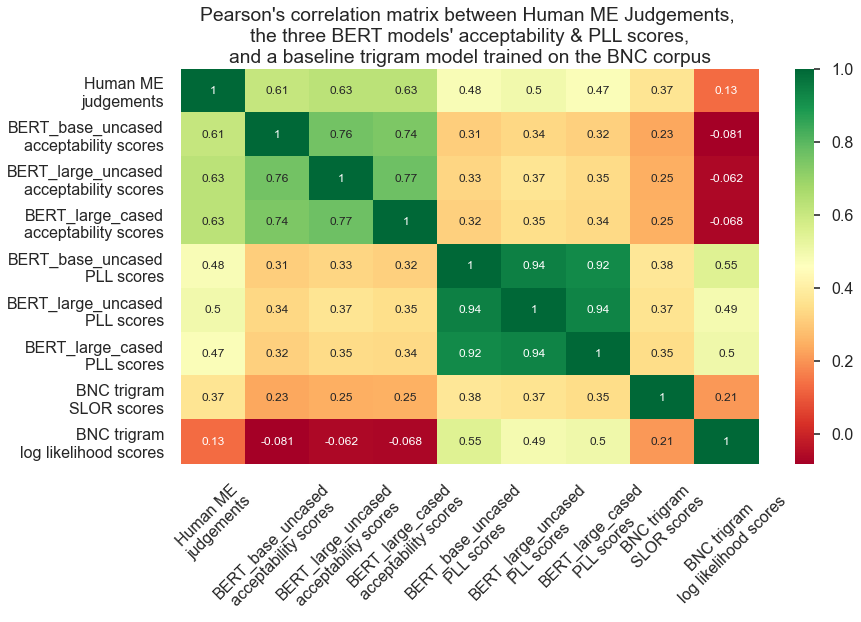

In [93]:
# Build matrix of correlations for plotting.
corr_df = aggregate[["id"] + measures].merge(human_judgements[["id", "judgement"]], on="id", how="left",
                            validate="many_to_one")
corr_df = corr_df.dropna()

# One graph without the BERT MLM data.
labels = ["Human ME\njudgements",
          "BERT_base_uncased\nacceptability scores",
          "BERT_large_uncased\nacceptability scores",
          "BERT_large_cased\nacceptability scores",
          "BERT_base_uncased\nPLL scores",
          "BERT_large_uncased\nPLL scores",
          "BERT_large_cased\nPLL scores",
          "BNC trigram\nSLOR scores",
          "BNC trigram\nlog likelihood scores"]
fig, ax = plt.subplots()


sns.heatmap(corr_df[["judgement", "bert-base-uncased_acc", "bert-large-uncased_acc",
                    "bert-large-cased_acc", "bert-base-uncased_mlm", 
                     "bert-large-uncased_mlm", "bert-large-cased_mlm", "slor", "logProb"]].corr(), 
            annot=True, cmap="RdYlGn", xticklabels=labels, yticklabels=labels, ax=ax)

for item in ax.get_xticklabels():
    item.set_rotation(45)

plt.title("Pearson's correlation matrix between Human ME Judgements, \n" +\
          "the three BERT models' acceptability & PLL scores,\n" +\
          "and a baseline trigram model trained on the BNC corpus")
plt.tight_layout()
plt.savefig("./figures/bert_acc_pll_correlation_matrix.png")
plt.show()

In [69]:
## Reformat the aggregated data for easier plotting.
aggregate = aggregate.melt(id_vars=["id", "dataset", "sentence", "sent_length"], value_vars=measures, 
                           var_name="measure", value_name="score")

# Finish with the human judgements.
# NOTE: Needed to do them last in order to have them as the dependent variable in the graphs.
aggregate = aggregate.merge(human_judgements[["id", "judgement"]], on="id", how="left",
                            validate="many_to_one")

# Drop rows that are missing values.
aggregate = aggregate.dropna()

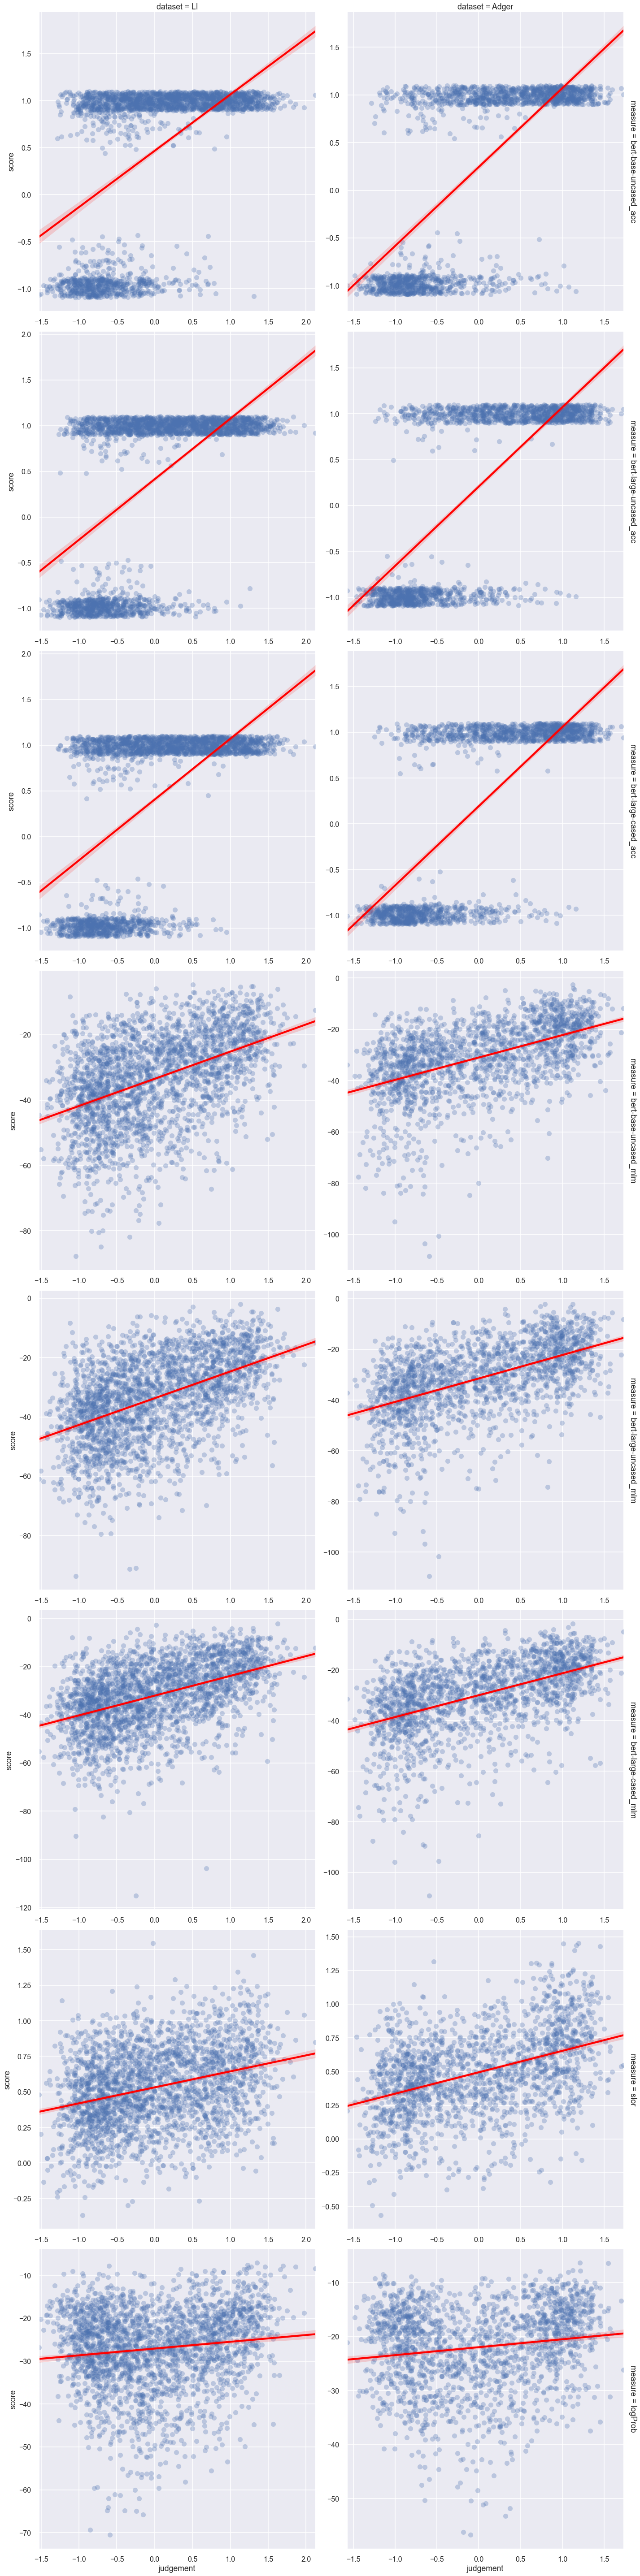

In [5]:
cols = ['LI', '']
g = sns.FacetGrid(aggregate, col='dataset', row='measure', height=10, aspect=1,
                  sharex=False, sharey=False, margin_titles=True)
g.map(sns.regplot, "judgement", "score", y_jitter=0.1, order=1, 
      scatter_kws={"alpha":0.3}, line_kws={"color":"red"})
#g.map(sns.scatterplot, "judgement", "score", y_jitter=0.1)

plt.show()

<---------- bert-base-uncased_delta vs human_judge_delta ---------->
PEARSON R SCORES:
All sentences:  (0.34297998091785864, 3.6573419368736306e-55)
LI sentences: (0.3774313932024466, 4.690874282265489e-37)
Adger sentences: (0.2515683525472266, 1.6818149359889152e-14)
MEAN SQUARE ERROR SCORES:
All sentences: 0.9971402440416315
LI sentences: 1.0513945923386943
Adger sentences: 0.9337533808595705
<---------- bert-large-uncased_delta vs human_judge_delta ---------->
PEARSON R SCORES:
All sentences:  (0.37716712159788585, 3.1815242669894873e-67)
LI sentences: (0.44144154736529245, 1.5217287314009243e-51)
Adger sentences: (0.2383771624790865, 3.9232340391394677e-13)
MEAN SQUARE ERROR SCORES:
All sentences: 0.9590008524305873
LI sentences: 0.9976328776039147
Adger sentences: 0.9138659835957472
<---------- bert-large-cased_delta vs human_judge_delta ---------->
PEARSON R SCORES:
All sentences:  (0.34696791790223513, 1.7047302451127844e-56)
LI sentences: (0.3643280261782253, 1.834161853659122e

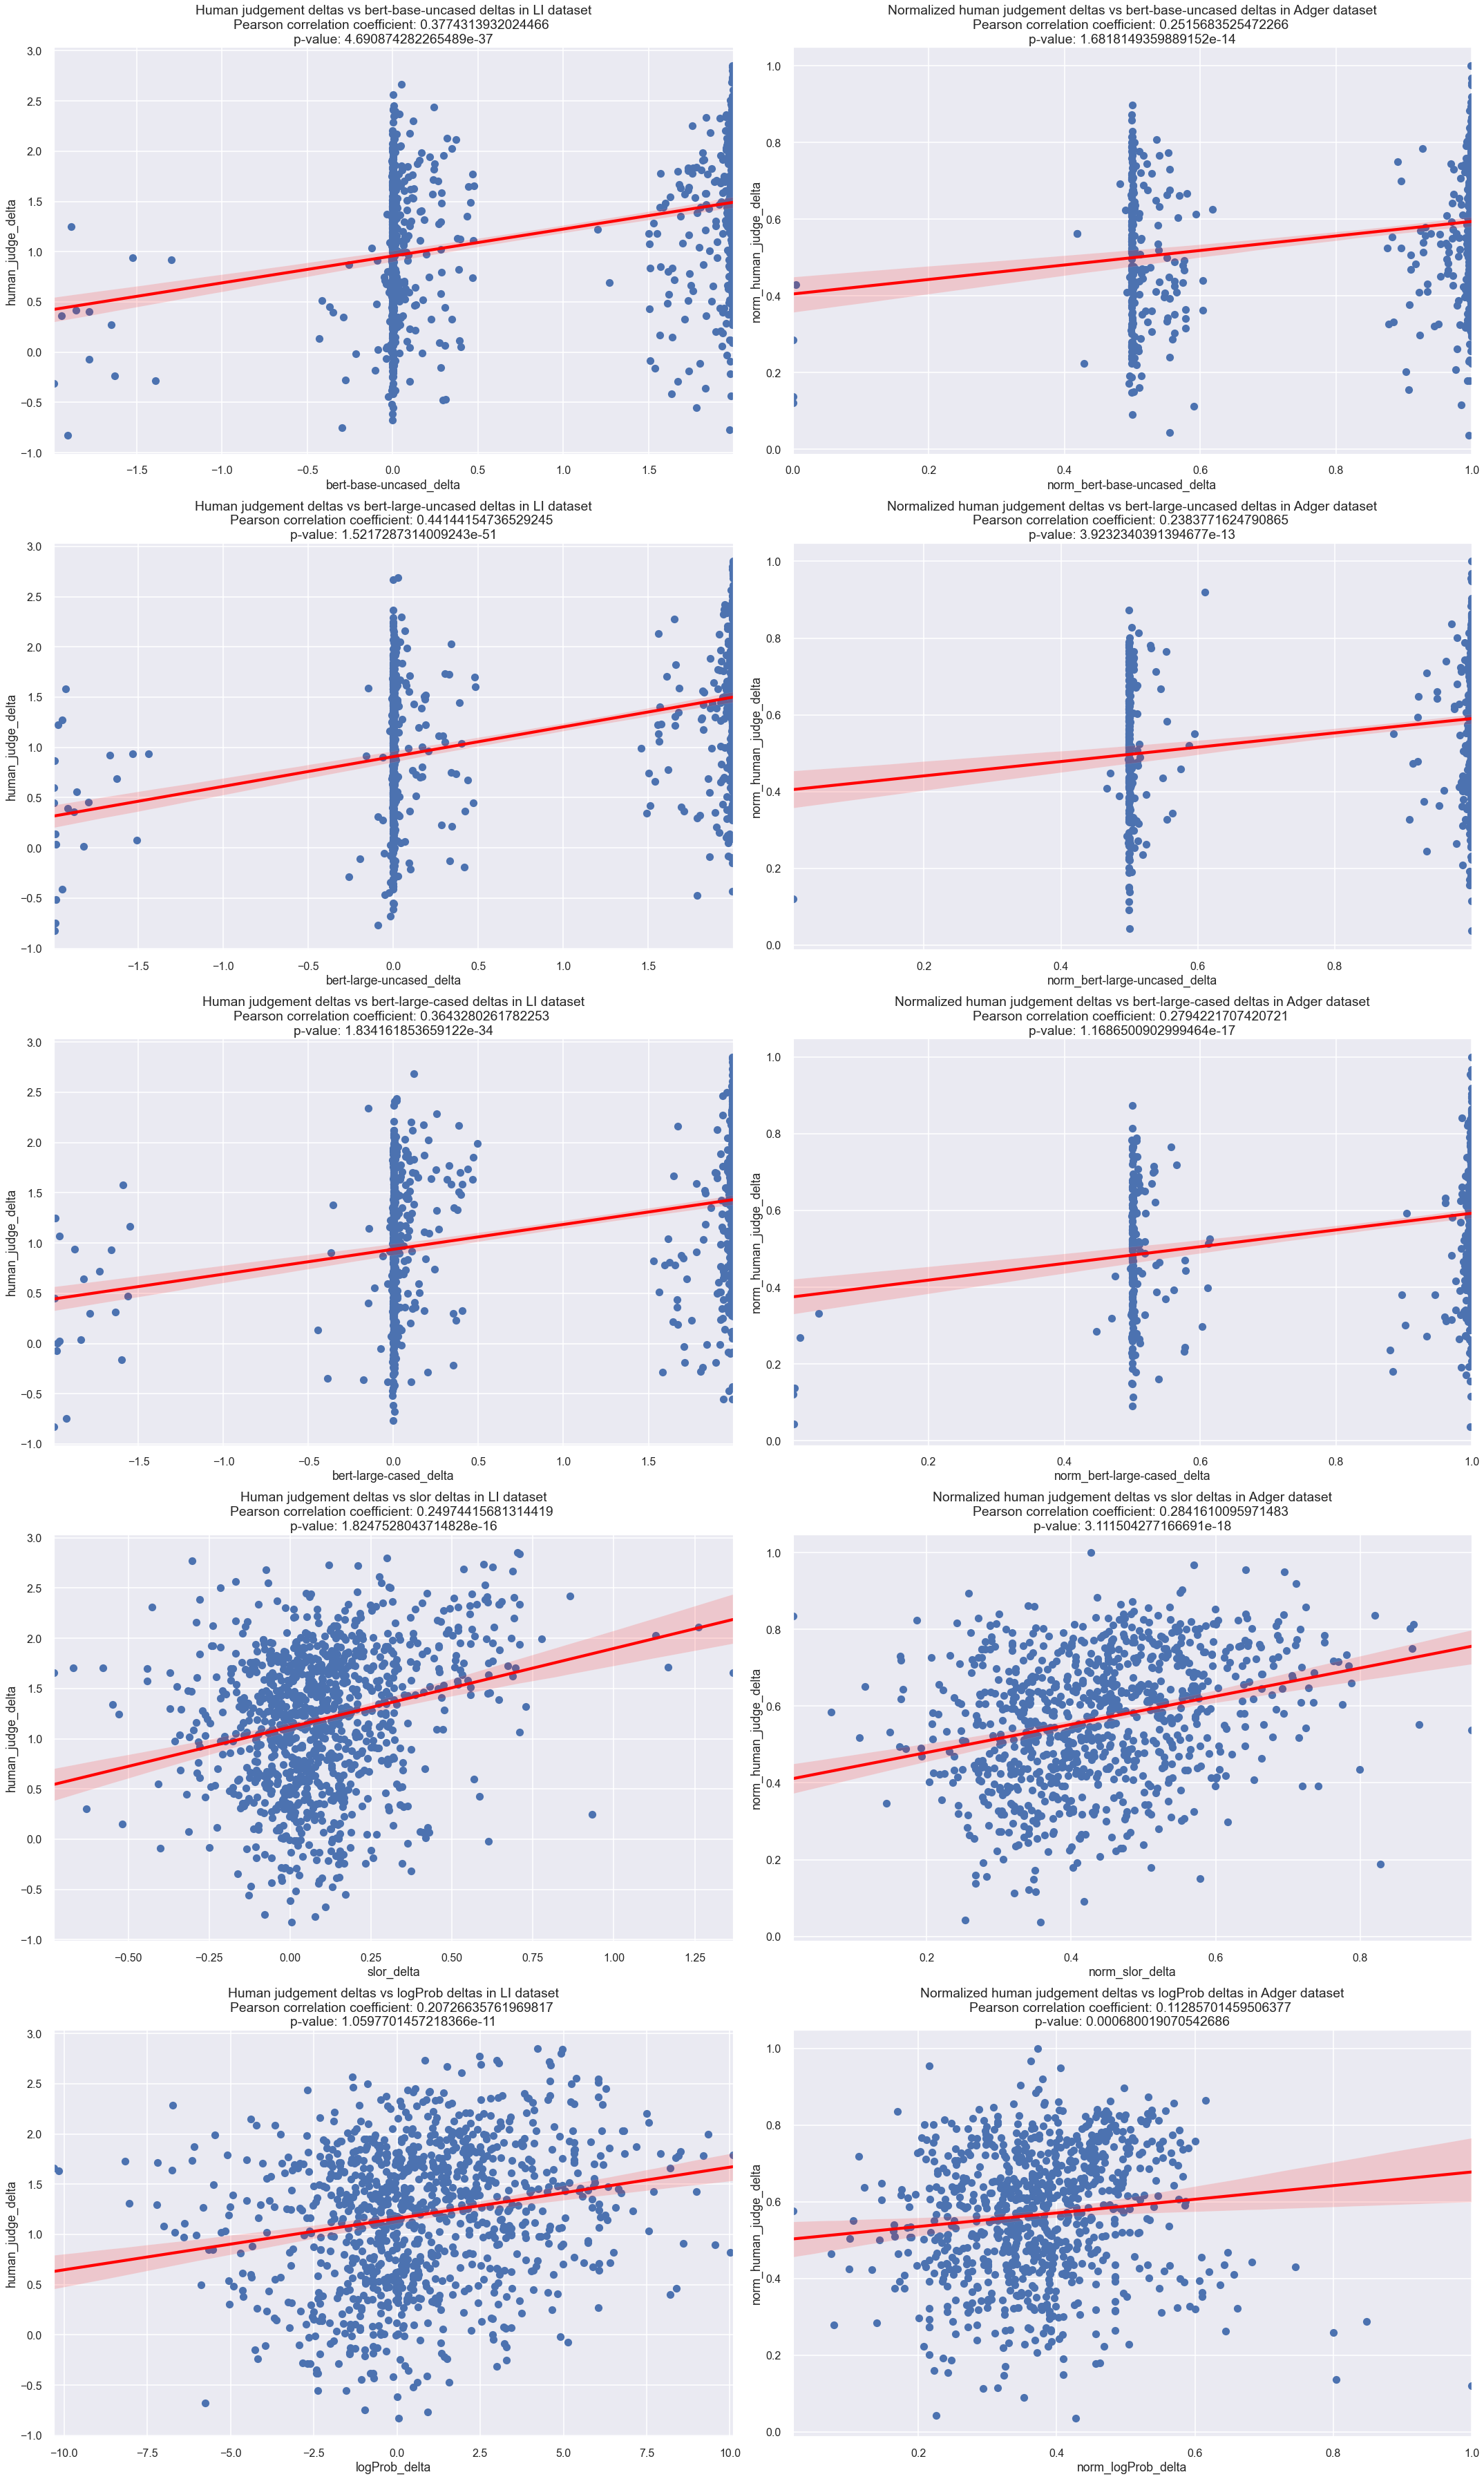

In [365]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(30, 50))

idx = 0 # to keep track of the axis for plotting.
for key, column in MEASURES_2_COLS.items():
    li_data = min_pairs.loc[min_pairs.dataset == "LI"]
    adger_data = min_pairs.loc[min_pairs.dataset == "Adger"]
    # Variable names to plot with seaborn.
    # First column.
    y0 = "human_judge_delta"
    x0 = column + "_delta"
    # Second column.
    y1 = "norm_" + y0
    x1 = "norm_" + x0
    
    # Seaborn scatterplot with regression line.
    sns.regplot(x=x0, y=y0, data=li_data, ax=axes[idx, 0],
               scatter_kws={"alpha":1}, line_kws={"color":"red"})
    sns.regplot(x=x1, y=y1, data=adger_data, ax=axes[idx, 1],
               scatter_kws={"alpha":1}, line_kws={"color":"red"})
    
    # Correlation coefficients and p-values for title.
    cc0, pvalue0 = pearsonr(li_data[x0], li_data[y0])
    cc1, pvalue1 = pearsonr(adger_data[x0], adger_data[y0])
    print("<----------", x0, "vs", y0, "---------->")
    print("PEARSON R SCORES:")
    print("All sentences: ", pearsonr(min_pairs[x0], min_pairs[y0]))
    print("LI sentences:", (cc0, pvalue0))
    print("Adger sentences:", (cc1, pvalue1))
    print("MEAN SQUARE ERROR SCORES:")
    print("All sentences:", mean_squared_error(min_pairs[y0], min_pairs[x0]))
    print("LI sentences:", mean_squared_error(li_data[y0], li_data[x0]))
    print("Adger sentences:", mean_squared_error(adger_data[y0], adger_data[x0]))
    # Titles.
    axes[idx, 0].set_title("Human judgement deltas vs {} deltas in LI dataset\n".format(column) +\
                           "Pearson correlation coefficient: {} \n".format(cc0) +\
                           "p-value: {}".format(pvalue0))
    axes[idx, 1].set_title("Normalized human judgement deltas vs {} deltas in Adger dataset\n".format(column) +\
                           "Pearson correlation coefficient: {} \n".format(cc1) +\
                           "p-value: {}".format(pvalue1))
    
    # Increment axis counter.
    idx += 1

plt.tight_layout()
plt.savefig("./output/all_three_regularized/model_deltas.jpg")
plt.show()

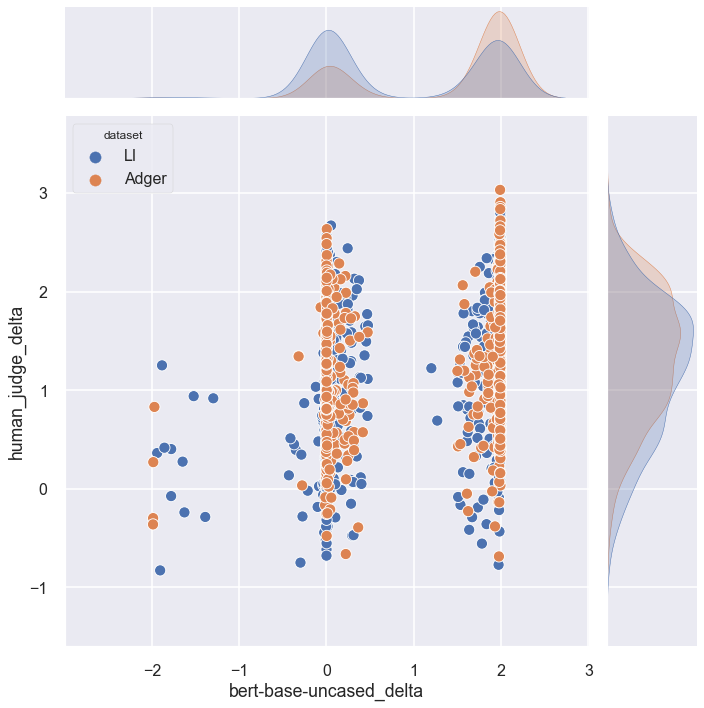

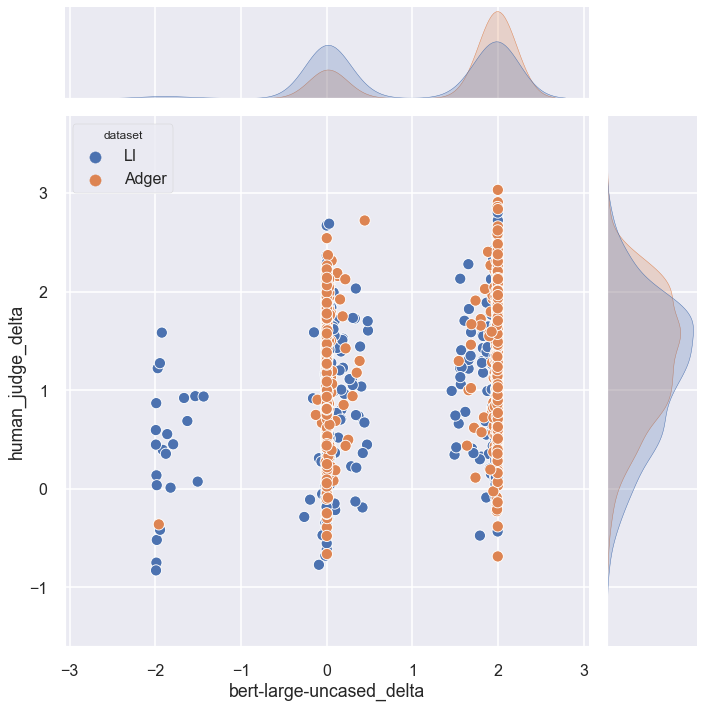

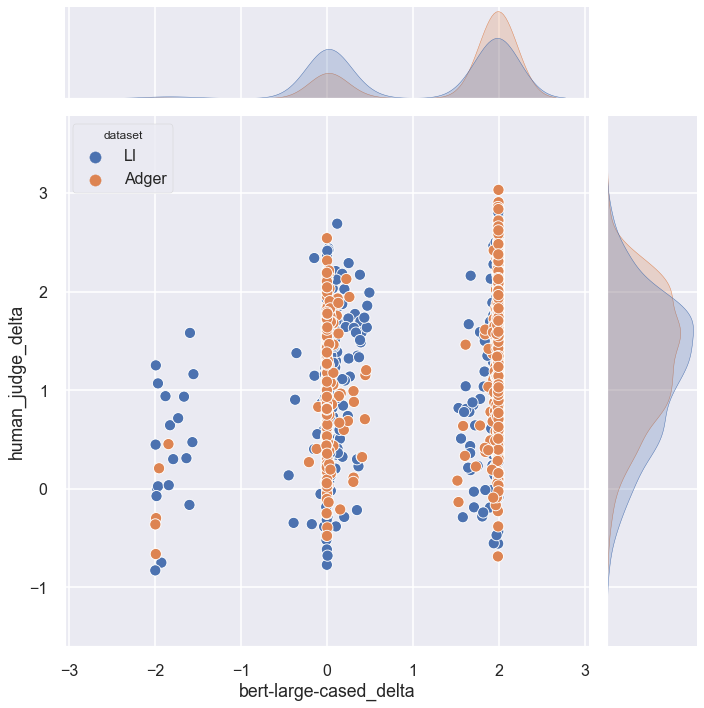

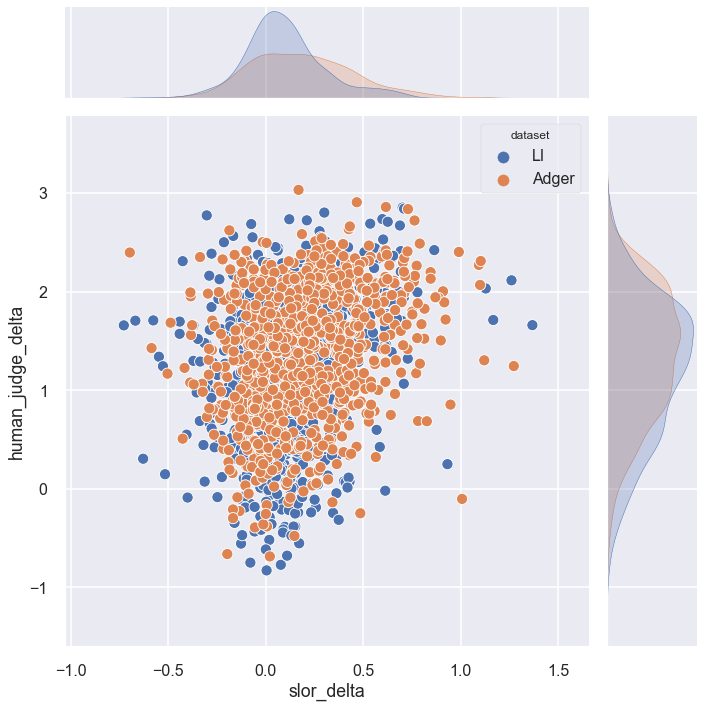

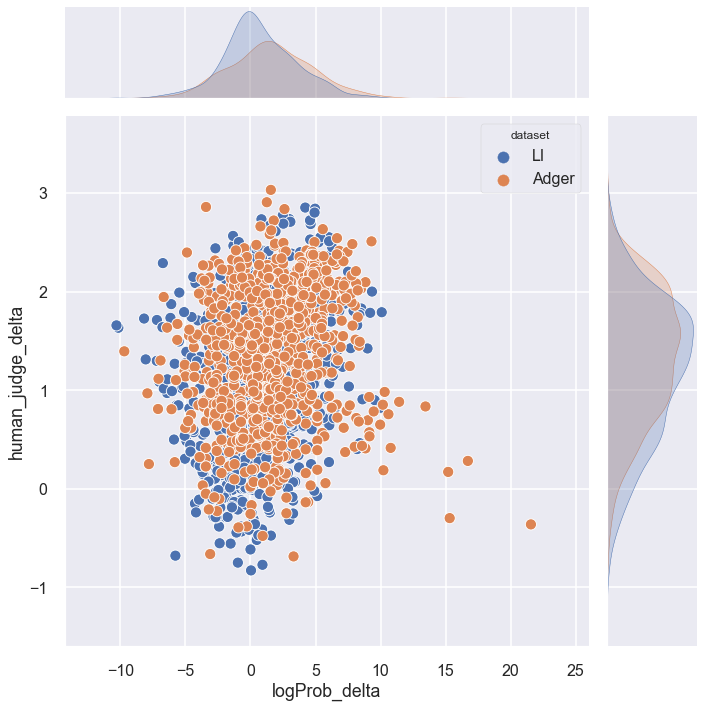

In [310]:

for key, column in MEASURES_2_COLS.items():
    y0 = "human_judge_delta"
    x0 = column + "_delta"
    
    # Seaborn scatterplot with density plot.
    sns.jointplot(x=x0, y=y0, hue="dataset", data=min_pairs, height=10)